# Experiment Evaluation: Angular-Metric with Distance TSP

The data is comparable to the vanilla *Angular-Metric TSP*. This makes the analysis straight forward. However, the results are slightly different.

The execution of the experiments have been identical to *Angular-Metric TSP* but on the more potent AlgRy03 and slightly extended instances (up to 90 vertices). The time limit is with 3600s (1hr) identical.

In [1]:
# Dependencies and setup
import json
import os
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_theme()
plt.rcParams.update({'figure.max_open_warning': 0
                    ,"text.usetex": True
                    ,"font.family": "serif"
                    })
sns.set_palette("tab10")
PAPER_WIDTH = 10

## Explaining the data

In [2]:
# Reading the preprocessed data. The data has been extracted from the repository of Eike's master's thesis.
t_experiments = pd.read_json("./00_angdist_data.json.zip")

* **num_vertices:** The number of vertices in this instance. Most of the instances have been created in 5-steps.
* **sparsification_technique:** The used sparsification technique. The complete graph has "complete".
* **ObjVal:** The objective value of the solution (either optimal or the best at timeout).
* **filename_instance:** The file of the instance. Use this to distinguish different instances. The name also states something about its properties.
* **Runtime:** The runtime in seconds. The time limit has been 3600s.
* **Status:** The status code. 2 means solved to optimality. For sparisified instances, the instance may be solved in time but infeasible.
* **ObjBound:** The lower bound. If Status==2, it should equal the ObjVal.
* **solver:** Just the name of the solver. Not of relevance.
* **GRB_OUT_Time:** A list with the corresponding times the of the next two lists.
* **GRB_OUT_BestBd:** A list of the best bounds obtained over time (at the time of the previous list)
* **GRB_OUT_Incumbent:** A list of the best solutions (ObjVal) over time (analogous to previous list).

In [3]:
# Just a preview on the data.
t_experiments

,num_vertices,sparsification_technique,ObjVal,filename_instance,Runtime,Status,ObjBound,solver,GRB_OUT_Time,GRB_OUT_BestBd,GRB_OUT_Incumbent
5,76,complete,490546.539038,pr76_76_0.json,14.144723,2,490546.539038,Angle_distance_tsp,"[1.0, 2.0, 6.0, 11.0, 12.0, 13.0, 14.0]","[480245.791, 480404.94, 480404.94, 480473.884,...","[529983.12983, 529983.13, 529983.13, 490546.54..."
25,70,complete,598836.950800,st70_70_0.json,115.266636,2,598836.950800,Angle_distance_tsp,"[13.0, 16.0, 21.0, 26.0, 30.0, 32.0, 35.0, 40....","[571682.649, 571682.649, 571682.649, 571682.64...","[718022.26482, 718022.265, 718022.265, 718022...."
40,51,complete,527984.939593,eil51_51_0.json,19.869005,2,527984.939593,Angle_distance_tsp,"[0.0, 1.0, 5.0, 6.0, 13.0, 15.0, 19.0]","[499978.517, 502202.363, 502576.597, 504550.44...","[621006.824, 567888.57283, 567888.573, 545849...."
46,41,complete,314717.547800,swiss42_42_0.json,6.868828,2,314717.547800,Angle_distance_tsp,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]","[294057.664, 294675.364, 295888.452, 296557.24...","[412269.402, 327070.693, 327070.693, 327070.69..."
57,14,complete,207325.251801,burma14_14_0.json,0.067097,2,207325.251801,Angle_distance_tsp,[0.0],[207325.252],[207325.2518]
...,...,...,...,...,...,...,...,...,...,...,...
29770,20,yao6-2,246048.582549,20210430_uniform_real_20_2.json,0.011137,2,246048.582549,Angle_distance_tsp,[0.0],[246048.583],[246048.58255]
29850,10,yao6-2,174122.461892,20210430_uniform_real_10_6.json,0.001266,2,174122.461892,Angle_distance_tsp,[0.0],[174122.462],[174122.462]
29899,60,yao6-2,534435.940830,20210430_uniform_real_60_9.json,0.372991,2,534435.940830,Angle_distance_tsp,[0.0],[531454.36],[534435.94083]
29925,20,yao6-2,293178.868982,20210430_uniform_real_20_3.json,0.012749,2,293178.868982,Angle_distance_tsp,[0.0],[293178.869],[293178.86898]


In [4]:
# Rounding the instance size to 5er-steps to ease the evaluation.
t_experiments["num_vertices"] = t_experiments["num_vertices"].apply(lambda x: round(x/5)*5)
# Sorting the data for the sparsification technique to have uniform plots without extra setup.
t_experiments.sort_values(by=["sparsification_technique"], inplace=True)

## 1. Feasibility

We again check if the sparsification techniques yield feasible, i.e., hamiltonian graphs. This is identical to Angular-Metric, thus, we do not expect any changes. The only difference is the extension of the instance set to up to 90 vertices.

In [5]:
only_larger_than = 30
num_instances = t_experiments[(t_experiments["num_vertices"]>=only_larger_than)]["filename_instance"].nunique()
t = t_experiments[(t_experiments["Status"]==3) & (t_experiments["num_vertices"]>=only_larger_than)].groupby("sparsification_technique")["filename_instance"].nunique()/num_instances
t

sparsification_technique
greedy2     0.592085
theta6-0    0.423135
theta6-1    0.414003
wspd2-1     0.021309
wspd2-2     0.007610
wspd3-1     0.065449
wspd3-2     0.013699
wspd4-1     0.086758
wspd4-2     0.010654
wspd5-1     0.097412
wspd5-2     0.024353
wspd6-1     0.108067
wspd6-2     0.027397
wspd7-1     0.111111
wspd7-2     0.035008
wspd8-1     0.112633
wspd8-2     0.028919
yao6-0      0.372907
yao6-1      0.343988
Name: filename_instance, dtype: float64

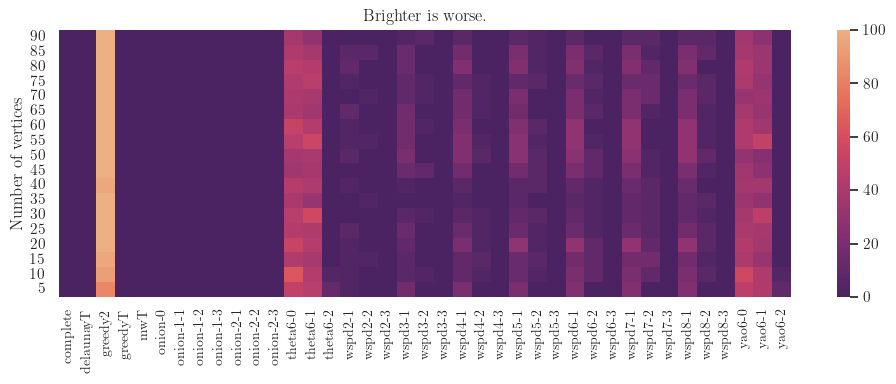

In [6]:
fig = plt.figure(figsize=(PAPER_WIDTH,4))
t = t_experiments.copy()
t["Infeasible"] = (t["Status"]==3).apply(lambda x: 100 if x else 0)
t_ = t.groupby(["num_vertices", "sparsification_technique"])["Infeasible"].mean().reset_index()
t_
sparsification_techniques = t["sparsification_technique"].unique()
t__ = pd.DataFrame()
for s in sparsification_techniques:
    column = t_[t_["sparsification_technique"]==s].groupby("num_vertices")["Infeasible"].mean().copy()
    t__[s]=column
#pd.melt(t_,id_vars=["sparsification_technique"], value_vars=["timeout"])
t__.sort_index(inplace=True, ascending=False)
sns.heatmap(data=t__, cmap="flare_r", xticklabels=True)
plt.xlabel("")
plt.yticks(rotation=0)
#plt.gca().set_xticks(range(len(list(sparsification_techniques))))
plt.xticks(rotation=90,fontsize=10)
#plt.set_xticklabels(list(range(len(sparsification_techniques))))
plt.ylabel("Number of vertices")
plt.title("Brighter is worse.")
plt.tight_layout()
plt.savefig("./output/feasibility.pdf")
plt.show()

These results are, as expected, identical to *Angular-Metric TSP*. We again ignore the sparsification techniques that are in 10% of the cases not feasible.

In [7]:
t = t_experiments[(t_experiments["Status"]==3) & (t_experiments["num_vertices"]>=only_larger_than)].groupby("sparsification_technique")["filename_instance"].nunique()/num_instances
techniques_to_ignore = list(t[t>0.1].index)
techniques_to_ignore

['greedy2',
 'theta6-0',
 'theta6-1',
 'wspd6-1',
 'wspd7-1',
 'wspd8-1',
 'yao6-0',
 'yao6-1']

In [8]:
t_experiments_feasible = t_experiments[~t_experiments["sparsification_technique"].isin(techniques_to_ignore)]

## 2. Solution Quality

Let us next look at the solution quality because bad solutions are not useful independent of how quick we can obtain them.

We are using *best upper bound/best lower bound* as metric (all bounds computed with timeout).

In [9]:
t = t_experiments_feasible.copy()
t = t[t["Status"]!=3]
lbs = t_experiments[t_experiments["sparsification_technique"]=="complete"].groupby("filename_instance")["ObjBound"].max()
t = pd.merge(left=t, right=lbs, left_on="filename_instance", right_index=True, suffixes=("", "_best"))
t["Gap"] = t["ObjVal"]/t["ObjBound_best"]

In [10]:
# Quick check that there are no corrupt results.
# Always check that the results are as expected. Tiny rounding errors are of course possible, thus, 0.99 instead of 1.0
t[t["Gap"]<=0.99]

,num_vertices,sparsification_technique,ObjVal,filename_instance,Runtime,Status,ObjBound,solver,GRB_OUT_Time,GRB_OUT_BestBd,GRB_OUT_Incumbent,ObjBound_best,Gap


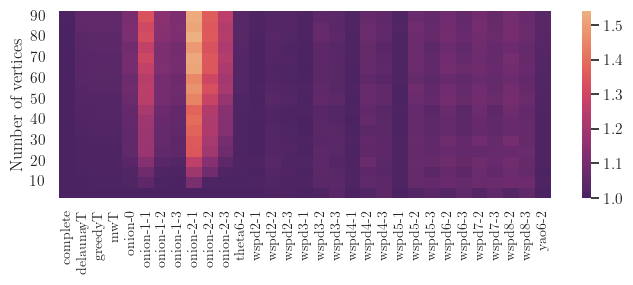

In [11]:
fig = plt.figure(figsize=(0.7*PAPER_WIDTH,3))
t_ = t.groupby(["num_vertices", "sparsification_technique"])["Gap"].mean().reset_index()
t_
sparsification_techniques = sorted(t["sparsification_technique"].unique())
t__ = pd.DataFrame()
for s in sparsification_techniques:
    column = t_[t_["sparsification_technique"]==s].groupby("num_vertices")["Gap"].mean().copy()
    t__[s]=column
#pd.melt(t_,id_vars=["sparsification_technique"], value_vars=["timeout"])
t__.sort_index(inplace=True, ascending=False)
sns.heatmap(data=t__, cmap="flare_r", xticklabels=True)
#plt.xlabel("Sparsification Technique")
plt.xlabel("")
plt.yticks(rotation=0)
#plt.gca().set_xticks(range(len(list(sparsification_techniques))))
plt.xticks(rotation=90,fontsize=10)
#plt.set_xticklabels(list(range(len(sparsification_techniques))))
plt.ylabel("Number of vertices")
#plt.title("Brighter is worse.")
plt.tight_layout()
plt.savefig("./output/solution_quality_heatmap.pdf")
plt.show()

The brighter the column, the worse the technique. The results are still reasonable with the worst technique being only up to around 50% above the lower bound. This time, the triangulations, some WSPDs, and the Yao6-2 sparsification show promising. The onion-graphs do not.

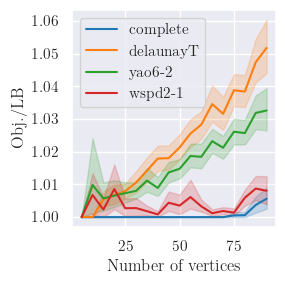

In [12]:
fig = plt.figure(figsize=(0.3*PAPER_WIDTH,3))
detail_sparsification_techniques = ["complete", "delaunayT", "wspd2-1", "yao6-2"]
t_ = t[t["sparsification_technique"].isin(detail_sparsification_techniques)]
sns.lineplot(data=t_, x="num_vertices", y="Gap", hue="sparsification_technique")
plt.legend(title="")
plt.xlabel("Number of vertices")
#plt.title("Lower is better.")
plt.tight_layout()
plt.ylabel("Obj./LB")
plt.savefig("./output/solution_quality_lineplot.pdf")
plt.show()

We see that within the time limit of 3600 seconds, the complete graph actually computes the best solutions, even if they are not optimal. The wspd-graphs are still reasonably close to the optimum with no visible increase. The Delaunay triangulation and the yao-Graphs are still very close to the lower bound but an increase is visible with the number of vertices.

### Solution Quality after 15 seconds

When we take a look at the objective value after 15 seconds, there are some differences but it is not absolutely clear. What can be noticed is that the triangulations are nearly identical to the complete graph.

In [13]:
seconds = 15
gap_for_no_solution = 2
column_name = f"ObjAfter{seconds}s"
column_name_gap = f"RelativeGapAfter{seconds}s"

def objective_at_time(instance, technique, time):
    t_ = t[(t["filename_instance"]==instance) & (t["sparsification_technique"]==technique)]
    row = t_.iloc[0]
    times = row["GRB_OUT_Time"]
    if type(times) is not list:
        return None
    objectives = row["GRB_OUT_Incumbent"]
    return min((objectives[i] for i, time_ in enumerate(times) if time_<=time), default=None)

def fill(row):
    try:
        return objective_at_time(row["filename_instance"], "complete", seconds)
    except IndexError or KeyError:
        #print("No value for", row["filename_instance"])
        return None

t[column_name]=t.apply(fill, axis=1)
t[column_name_gap]=t[column_name]/t["ObjBound_best"]
t[column_name_gap].fillna(gap_for_no_solution, inplace=True)

Text(55.22049813741006, 0.5, 'Number of vertices')

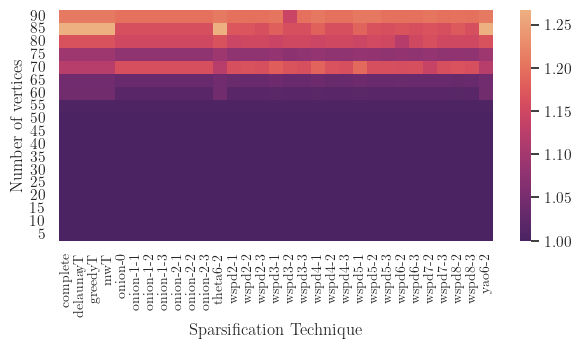

In [14]:
fig = plt.figure(figsize=(0.7*PAPER_WIDTH,3))
t_ = t.groupby(["num_vertices", "sparsification_technique"])[column_name_gap].mean().reset_index()
t_
sparsification_techniques = sorted(t["sparsification_technique"].unique())
t__ = pd.DataFrame()
for s in sparsification_techniques:
    column = t_[t_["sparsification_technique"]==s].groupby("num_vertices")[column_name_gap].mean().copy()
    t__[s]=column
#pd.melt(t_,id_vars=["sparsification_technique"], value_vars=["timeout"])
t__.sort_index(inplace=True, ascending=False)
sns.heatmap(data=t__, cmap="flare_r", xticklabels=True, yticklabels=True)
plt.xlabel("Sparsification Technique")
plt.yticks(rotation=0)
#plt.gca().set_xticks(range(len(list(sparsification_techniques))))
plt.xticks(rotation=90,fontsize=10)
#plt.set_xticklabels(list(range(len(sparsification_techniques))))
plt.ylabel("Number of vertices")
#plt.title("Brighter is worse.")

## 2. Runtime

Let us next take a look on the runtime. We are comparing a lot of different strategies which are too much for a lineplot. Instead we do a heatmap that shows us, which instances could still be solved wihtin a strict time limit. Infeasible instances are considered as unsolved (they are slightly worse but in both cases we do not obtain the desired solution from the sparsification).

From this heatmap, we select a few intersting strategies for which we then also compare the concrete runtime in a lineplot.

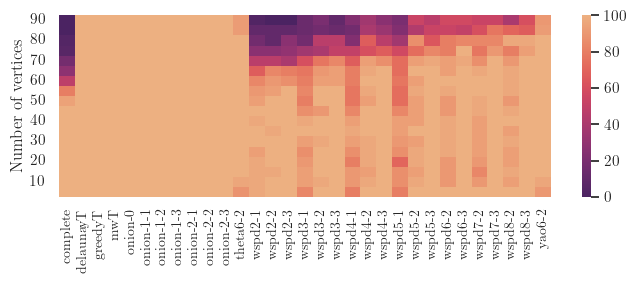

In [15]:
TIMEOUT_AFTER_S = 30
fig = plt.figure(figsize=(0.7*PAPER_WIDTH,3))

t = t_experiments_feasible.copy()
t["timeout"] = (t["Runtime"]>TIMEOUT_AFTER_S).apply(lambda x: 0 if x else 100)
t.loc[t["Status"]!=2, "timeout"]=0
t_ = t.groupby(["num_vertices", "sparsification_technique"])["timeout"].mean().reset_index()
t_
sparsification_techniques = t["sparsification_technique"].unique()
t__ = pd.DataFrame()
for s in sparsification_techniques:
    column = t_[t_["sparsification_technique"]==s].groupby("num_vertices")["timeout"].mean().copy()
    t__[s]=column
#pd.melt(t_,id_vars=["sparsification_technique"], value_vars=["timeout"])
t__.sort_index(inplace=True, ascending=False)
sns.heatmap(data=t__, cmap="flare_r", xticklabels=True, vmin=0)
#plt.xlabel("Sparsification Technique")
plt.xlabel("")
plt.yticks(rotation=0)
#plt.gca().set_xticks(range(len(list(sparsification_techniques))))
plt.xticks(rotation=90,fontsize=10)
#plt.set_xticklabels(list(range(len(sparsification_techniques))))
plt.ylabel("Number of vertices")
#plt.title(f"Solved within {TIMEOUT_AFTER_S}s. Brighter is better.")
plt.tight_layout()
plt.savefig("./output/runtime_heatmap.pdf")
plt.show()

/tmp/ipykernel_9882/1452037029.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=t_, x="num_vertices", y="Runtime", hue="sparsification_technique", style="sparsification_technique",ci=None)


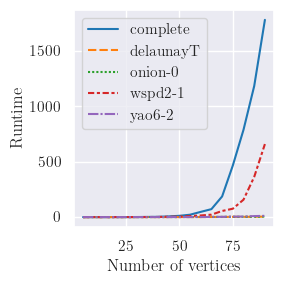

In [16]:
INTERESTING_STRATEGIES = ["complete", "delaunayT", "onion-0", "wspd2-1", "yao6-2"]
fig = plt.figure(figsize=(0.3*PAPER_WIDTH,3))
t_ = t[t["sparsification_technique"].isin(INTERESTING_STRATEGIES)]
sns.lineplot(data=t_, x="num_vertices", y="Runtime", hue="sparsification_technique", style="sparsification_technique",ci=None)
plt.legend(title="")
plt.xlabel("Number of vertices")
plt.tight_layout()
plt.savefig("./output/runtime_lineplot.pdf")
plt.show()

The WSPDs are relatively slow (still faster than complete) but the other strategies are extremely fast.

In [17]:
fig = plt.figure(figsize=(0.7*PAPER_WIDTH,4))

t = t_experiments_feasible.copy()
t["timeout"] = (t["Runtime"]>TIMEOUT_AFTER_S).apply(lambda x: 0 if x else 1)
t.loc[t["Status"]!=2, "Runtime"]=3600
t_ = t.groupby(["sparsification_technique"])["Runtime"].mean().reset_index()
t_


,sparsification_technique,Runtime
0,complete,251.948286
1,delaunayT,0.805222
2,greedyT,0.486345
3,mwT,0.490213
4,onion-0,1.165233
5,onion-1-1,0.036479
6,onion-1-2,0.173374
7,onion-1-3,0.290462
8,onion-2-1,0.063993
9,onion-2-2,0.195683


<Figure size 700x400 with 0 Axes>

The onion-hulls are extremely fast. The lower wspd graphs are still visible faster than complete and the higher wspd graphs are much faster, but not as fast as onion.

## Quality/Time Ration

Let us compare the quality per time ratio.

In [18]:

def get_data_for_obj_time(num_vertices):
    INTERESTING_STRATEGIES = ["complete", "delaunayT", "wspd2-1", "yao6-2"]
    RANGE = list(range(0, 100))
    default_value = 3
    t = t_experiments_feasible.copy()
    t = t[t["num_vertices"]==num_vertices]
    t = t[t["sparsification_technique"].isin(INTERESTING_STRATEGIES)]
    if 3 in t["Status"].unique():
        print("WARNING: CONTAINS INFEASIBLE DATA")
    t = t[t["Status"]!=3]
    lbs = t_experiments[t_experiments["sparsification_technique"]=="complete"].groupby("filename_instance")["ObjBound"].max()
    t = pd.merge(left=t, right=lbs, left_on="filename_instance", right_index=True, suffixes=("", "_best"))
    def objective_at_time(row, time):
        times = row["GRB_OUT_Time"]
        if type(times) is not list:
            return float("inf")
        objectives = row["GRB_OUT_Incumbent"]
        return min((objectives[i] for i, time_ in enumerate(times) if time_<=time), default=float("inf"))
    relevant_times = RANGE
    data = {"strat": [], "gap": [], "time": [], "n": []}
    for i, row in t.iterrows():
        for t in relevant_times:
            data["strat"].append(row["sparsification_technique"])
            obj = objective_at_time(row, t)
            data["gap"].append(min(default_value, obj/row["ObjBound_best"] if obj<float("inf") else default_value))
            data["time"].append(t)
            data["n"].append(row["num_vertices"])
    return data

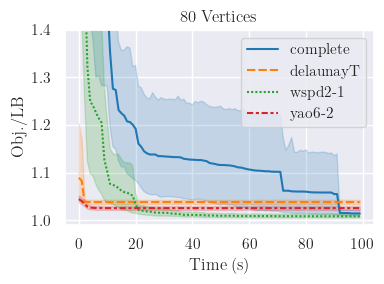

In [19]:
t_ = pd.DataFrame(data=get_data_for_obj_time(80))
t_.sort_values(by="strat", inplace=True)
#t_ = t_.groupby(["time", "strat"])[["gap"]].median().reset_index()
fig = plt.figure(figsize=(0.4*PAPER_WIDTH, 3))
sns.lineplot(data=t_, x="time", y="gap", hue="strat", style="strat")
plt.ylim(0.99, 1.4)
plt.legend(title=None)
plt.ylabel("Obj./LB")
plt.xlabel("Time (s)")
plt.title("80 Vertices")
plt.tight_layout()
plt.savefig("./output/gap_over_time_80.pdf")
plt.show()

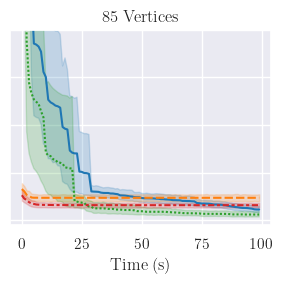

In [20]:
t_ = pd.DataFrame(data=get_data_for_obj_time(85))
t_.sort_values(by="strat", inplace=True)
#t_ = t_.groupby(["time", "strat"])[["gap"]].median().reset_index()
fig = plt.figure(figsize=(0.3*PAPER_WIDTH, 3))
sns.lineplot(data=t_, x="time", y="gap", hue="strat", style="strat")
plt.ylim(0.99, 1.4)
plt.gca().get_legend().remove()
plt.ylabel("")
plt.xlabel("Time (s)")
plt.title("85 Vertices")
plt.gca().set_yticklabels([])
plt.tight_layout()
plt.savefig("./output/gap_over_time_85.pdf")
plt.show()

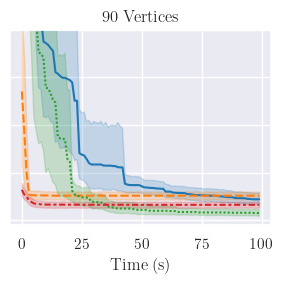

In [21]:
t_ = pd.DataFrame(data=get_data_for_obj_time(90))
t_.sort_values(by="strat", inplace=True)
#t_ = t_.groupby(["time", "strat"])[["gap"]].median().reset_index()
fig = plt.figure(figsize=(0.3*PAPER_WIDTH, 3))
sns.lineplot(data=t_, x="time", y="gap", hue="strat", style="strat")
plt.ylim(0.99, 1.4)
plt.gca().get_legend().remove()
plt.ylabel("")
plt.xlabel("Time (s)")
plt.title("90 Vertices")
plt.gca().set_yticklabels([])
plt.tight_layout()
plt.savefig("./output/gap_over_time_90.pdf")
plt.show()

In [22]:
t_[t_["time"]==50].groupby("strat")["gap"].mean()

strat
complete     1.071740
delaunayT    1.051786
wspd2-1      1.021847
yao6-2       1.032613
Name: gap, dtype: float64

We can see that the Yao-Graph has a very strong start but quickly reaches its limit. The WSPD-Graph is slower to solve but can maintain its slight lead to the complete graph for a longer time. This indicates the Yao-Graph to be a great selection of edges to begin the optimization, then to extend it with MWPD, before working on the complete graph.

The complete graph seems to perform better on the instances with 85 vertices than the instances with 80 vertices. This may be because the 80 vertex instances has one difficult instance that increases the average. Note that the gap is limited to 3 as there can be some very high values in the beginning that would completely destroy the mean.